<a href="https://colab.research.google.com/github/LisaLi1224/Eddymemory/blob/main/eddymemory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [382]:
#!pip install signalz
import matplotlib.pyplot as plt
import numpy as np
import math
import signalz
from signalz.misc import check_type_or_raise
from signalz.generators.gaussian_white_noise import gaussian_white_noise
from signalz.generators.uniform_white_noise import uniform_white_noise
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import math

In [383]:
# generate red-noise time series
# source: https://github.com/matousc89/signalz/blob/master/signalz/generators/brownian_noise.py
def brownian_noise(n, leak=0., start=0, std=1., source="gaussian"):
    # check inputs
    check_type_or_raise(n, int, "n")
    check_type_or_raise(leak, float, "leak")
    if not 0. <= leak < 1:
        raise ValueError("Leak must be between 0. and 1.")
    # generate white noise
    if source == "gaussian":
        x = np.random.normal(0, std, n)
    elif source == "uniform":
        x = np.random.uniform(-std / 2., std / 2., n)
    else:
        raise ValueError("Source must be gaussian or uniform")
    # add offset
    x[0] = start
    # integrate the white noise
    for i in range(1, n):
        x[i] += x[i - 1] * (1 - leak)
    return x


size of pre_kernel: 100
size of tspan_kernel: 100
size of tspan_convolved: 201


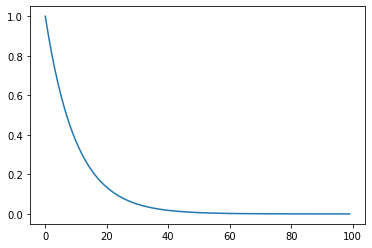

In [384]:
time_interval = 6 # corresponding time interval duration in say days
N_points = 300 # red-noise vector length


# define pre-defined kernel
tau = 0.2
tspan = np.linspace(0, time_interval, N_points)
dt = tspan[1]-tspan[0]
pre_kernel = np.exp(-tspan/tau)
kernel_size = 100 # truncate the kernel to include some small number of points since we are assuming it decays with time
pre_kernel = pre_kernel[:kernel_size] # now kernel has a smaller number of points relative to the Tgradient time series
print('size of pre_kernel: ' + str(len(pre_kernel)))
tspan_kernel = tspan[:kernel_size]
print('size of tspan_kernel: ' + str(len(tspan_kernel)))

tspan_convolved = tspan[len(pre_kernel)-1:] # the correct way of assigning time to the convolved timeseries
print('size of tspan_convolved: ' + str(len(tspan_convolved)))
plt.plot(pre_kernel)

In [385]:
# red-noise vector length of m_sample
m_sample = 6500; #6500-7000
temp_grad = np.zeros((m_sample,N_points,1))
F_flux = np.zeros((m_sample,N_points - kernel_size + 1,1))
for i in range(m_sample):
  temp_grad[i,:,0] = brownian_noise(N_points, leak=0.1, start=0, std=1, source='gaussian')
  F_flux[i,:,0] = np.convolve(pre_kernel, temp_grad[i,:,0], mode='valid')

# normalized series
#F_flux=F_flux/np.std(F_flux);  
#temp_grad=temp_grad/np.std(temp_grad);


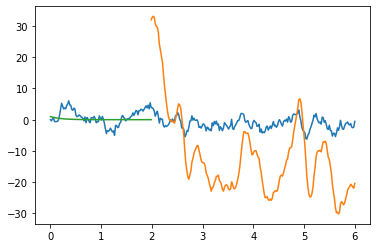

In [386]:
plt.plot(tspan, temp_grad[1,:,0])
plt.plot(tspan_convolved, F_flux[1,:,0])

plt.plot(tspan_kernel, pre_kernel)

In [387]:
# build single layer conv1d model
input_series = keras.layers.Input(temp_grad.shape[1:])
output_series = keras.layers.Conv1D(filters=1, padding='valid', kernel_size=kernel_size, strides=1, activation='linear', input_shape=(temp_grad.shape[1:]))(input_series)
model = keras.Model(input_series, output_series)
model.compile(
    optimizer='adam',
    loss= 'mean_squared_error',
    metrics=['mean_squared_error'])
model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 300, 1)]          0         
                                                                 
 conv1d_31 (Conv1D)          (None, 201, 1)            101       
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [388]:
# split train and test sets
X_train, X_rem, y_train, y_rem = train_test_split(temp_grad,F_flux, train_size=0.8)

In [389]:
# train the model
model.fit(X_train, y_train, epochs=50, validation_data = (X_rem, y_rem))

Epoch 1/50
163/163 [==============================] - 2s 10ms/step - loss: 195.9782 - mean_squared_error: 195.9781 - val_loss: 128.5671 - val_mean_squared_error: 128.5671
Epoch 2/50
163/163 [==============================] - 2s 10ms/step - loss: 92.4473 - mean_squared_error: 92.4473 - val_loss: 64.0937 - val_mean_squared_error: 64.0937
Epoch 3/50
163/163 [==============================] - 3s 17ms/step - loss: 47.1479 - mean_squared_error: 47.1479 - val_loss: 33.6996 - val_mean_squared_error: 33.6996
Epoch 4/50
163/163 [==============================] - 3s 17ms/step - loss: 25.3226 - mean_squared_error: 25.3227 - val_loss: 18.5870 - val_mean_squared_error: 18.5870
Epoch 5/50
163/163 [==============================] - 2s 9ms/step - loss: 14.2867 - mean_squared_error: 14.2867 - val_loss: 10.7517 - val_mean_squared_error: 10.7517
Epoch 6/50
163/163 [==============================] - 2s 9ms/step - loss: 8.4371 - mean_squared_error: 8.4371 - val_loss: 6.4863 - val_mean_squared_error: 6.4863


In [390]:
# use model to predict y_rem
y_pred = model.predict(X_rem)

41/41 [==============================] - 0s 2ms/step


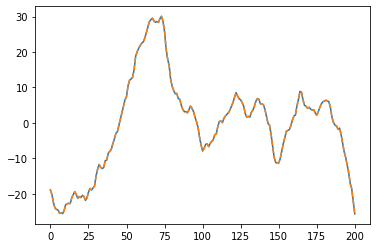

In [391]:
plt.plot(y_rem[2,:,0])
plt.plot(y_pred[2,:,0],'--')

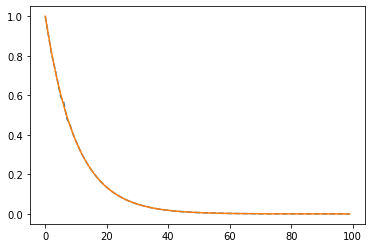

In [392]:
# get the kernel
conv_kernel = model.weights[0][:,0,0]
a = tf.constant(conv_kernel)
conv_kernel = a.numpy()
conv_kernel = conv_kernel[::-1]
plt.plot(conv_kernel,'--')
plt.plot(pre_kernel)